In [ ]:
!pip install yahoofinancials
from yahoofinancials import YahooFinancials
from datetime import datetime
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.layers import Flatten
from keras import backend as K
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt

**Fetch Data and Convert to Features**

In [ ]:
def get_data(ticker, start_date, end_date):
    """
    Retrieve historical stock price data from Yahoo Finance for a given ticker and date range.

    Parameters:
    ticker (str): Ticker symbol of the stock.
    start_date (str): Start date in 'YYYY-MM-DD' format.
    end_date (str): End date in 'YYYY-MM-DD' format.

    Returns:
    pandas.DataFrame: DataFrame containing historical stock price data.
    """
    date_range = pd.bdate_range(start=start_date, end=end_date)
    values = pd.DataFrame({'Date': date_range})
    values['Date'] = pd.to_datetime(values['Date'])
    data = YahooFinancials(ticker)
    data = data.get_historical_price_data(start_date, end_date, "daily").copy()
    return pd.DataFrame(data[ticker]["prices"])[['date', 'open', 'high', 'low', 'adjclose', 'volume']]

In [ ]:
#Get the stock price from YahooFinance and convert them to pandas dataframe
ticker = 'AAPL'
start_date = '2017-01-01'
end_date = '2024-01-01'

date_range = pd.bdate_range(start=start_date, end=end_date)
df = pd.DataFrame({'Date': date_range})
df['Date'] = pd.to_datetime(df['Date'])

price = get_data(ticker, start_date, end_date)
price.columns = ['DateTime', 'Open', 'High', 'Low', 'Close', 'Volume']
price['DateTime'] = price['DateTime'].apply(lambda x: datetime.fromtimestamp(x))
price = price.fillna(method="ffill", axis=0).fillna(method="bfill", axis=0)
price = price.set_index('DateTime')
price_copy = price

price['Symbol'] = ticker
print(f"Ticker {ticker}: ")
print(f"From {start_date}")
print(price['Close'].head())
print(f"Until {end_date}")
print(price['Close'].tail())

Ticker AAPL: 
From 2017-01-01
DateTime
2017-01-03 14:30:00    26.952703
2017-01-04 14:30:00    26.922535
2017-01-05 14:30:00    27.059456
2017-01-06 14:30:00    27.361118
2017-01-09 14:30:00    27.611731
Name: Close, dtype: float64
Until 2024-01-01
DateTime
2023-12-22 14:30:00    193.091385
2023-12-26 14:30:00    192.542816
2023-12-27 14:30:00    192.642548
2023-12-28 14:30:00    193.071426
2023-12-29 14:30:00    192.024185
Name: Close, dtype: float64


In [ ]:
#Split into train and test dataset, train is from 2017-01-01 to 2022-06-30, test is from 2022-06-30 to 2023-12-29. Around 80/20
target = 'Close'
train_start = start_date
train_end = '2022-06-30'
test_start = '2022-06-30'
train_data = price[train_start:train_end].iloc[:,3:4].values
test_data = price[test_start:].iloc[:,3:4].values

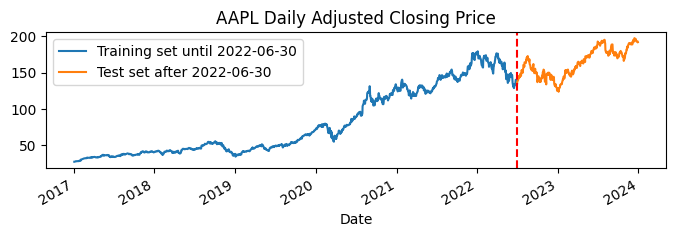

In [ ]:
price[target][train_start:train_end].plot(figsize=(8,2),legend=True)
price[target][test_start:].plot(figsize=(8,2),legend=True)
plt.legend([f'Training set until {train_end}',f'Test set after {test_start}'])
plt.axvline(x=test_start, color='r', linestyle='--')
plt.xlabel('Date')
plt.title(f'{ticker} Daily Adjusted Closing Price')
plt.show()

In [ ]:
#Data Normalization
sc = MinMaxScaler(feature_range=(0,1))
train_sc = sc.fit_transform(train_data)

In [ ]:
#create data sets such that 7 past values generate one output
past_days = 7
x_train = []
y_train = []
for i in range(past_days,train_data.shape[0]):
    x_train.append(train_sc[i-past_days:i,0])
    y_train.append(train_sc[i,0])
x_train, y_train = np.array(x_train), np.array(y_train)

print(f"First training sample and target: {x_train[0], y_train[0]}")
print(f"Second training sample and target: {x_train[1], y_train[1]}")

First training sample and target: (array([0.00019775, 0.        , 0.0008975 , 0.00287485, 0.00451758,
       0.00470014, 0.00567359]), 0.004913018422362553)
Second training sample and target: (array([0.        , 0.0008975 , 0.00287485, 0.00451758, 0.00470014,
       0.00567359, 0.00491302]), 0.004593607087400975)


In [ ]:
#Shuffle
x_train = x_train.reshape((x_train.shape[0], x_train.shape[1], 1))
idx = np.random.permutation(len(x_train))
x_train = x_train[idx]
y_train = y_train[idx]
print(f"Training params shape: {x_train.shape}")
print(f"Training target shape: {y_train.shape}")

Training params shape: (1376, 7, 1)
Training target shape: (1376,)


**Transformer Model**

In [ ]:
#Encoder
def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    """
    Transformer encoder layer for the model.

    Parameters:
    inputs (tensorflow.Tensor): Input tensor.
    head_size (int): Size of attention head.
    num_heads (int): Number of attention heads.
    ff_dim (int): Dimension of feed-forward network.
    dropout (float, optional): Dropout rate. Defaults to 0.

    Returns:
    tensorflow.Tensor: Transformed tensor.
    """
    x = layers.LayerNormalization(epsilon=1e-6)(inputs) #embedding
    x = layers.MultiHeadAttention(key_dim=head_size, num_heads=num_heads, dropout=dropout)(x, x) #attention
    x = layers.Dropout(dropout)(x)
    res = x + inputs

    x = layers.LayerNormalization(epsilon=1e-6)(res)
    x = layers.Conv1D(filters=ff_dim, kernel_size=1, activation = "relu")(x)
    x = layers.Dropout(dropout)(x)
    x = layers.Conv1D(filters=inputs.shape[-1], kernel_size=1)(x)
    return x + res

In [ ]:
#Model
def transformer_model(
    input_shape,
    head_size,
    num_heads,
    ff_dim,
    num_transformer_blocks,
    mlp_units,
    dropout=0,
    mlp_dropout=0,
):
    """
    Define a transformer-based deep learning model for stock price prediction.

    Parameters:
    input_shape (tuple): Input shape of the model.
    head_size (int): Size of attention head.
    num_heads (int): Number of attention heads.
    ff_dim (int): Dimension of feed-forward network.
    num_transformer_blocks (int): Number of transformer blocks in the model.
    mlp_units (list): List of units in each layer of the feed-forward network.
    dropout (float, optional): Dropout rate. Defaults to 0.
    mlp_dropout (float, optional): Dropout rate for MLP layers. Defaults to 0.

    Returns:
    tensorflow.keras.Model: Transformer model.
    """
    inputs = keras.Input(shape=input_shape)
    x = inputs

    for _ in range(num_transformer_blocks):
        x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout)

    x = layers.GlobalAveragePooling1D(data_format="channels_first")(x)
    for dim in mlp_units:
        x = layers.Dense(dim, activation="elu")(x)
        x = layers.Dropout(mlp_dropout)(x)
    outputs = layers.Dense(1, activation="linear")(x)
    return keras.Model(inputs, outputs)

In [ ]:
#Learning Rate Scheduler
def warmup_scheduler(epoch, lr, warmup_epochs=30, decay_epochs=100, initial_lr=1e-6, base_lr=1e-3, min_lr=5e-5):
    """
    Learning rate scheduler for warmup and decay.

    Parameters:
    epoch (int): Current epoch.
    lr (float): Current learning rate.
    warmup_epochs (int): Number of warmup epochs.
    decay_epochs (int): Number of decay epochs.
    initial_lr (float): Initial learning rate.
    base_lr (float): Base learning rate.
    min_lr (float): Minimum learning rate.

    Returns:
    float: Updated learning rate.
    """
    if epoch <= warmup_epochs:
        pct = epoch / warmup_epochs
        return ((base_lr - initial_lr) * pct) + initial_lr

    if epoch > warmup_epochs and epoch < warmup_epochs+decay_epochs:
        pct = 1 - ((epoch - warmup_epochs) / decay_epochs)
        return ((base_lr - min_lr) * pct) + min_lr

    return min_lr

In [ ]:
#Model params and training
Transformer = transformer_model(
    input_shape = x_train.shape[1:],
    head_size=46,
    num_heads=60,
    ff_dim=55,
    num_transformer_blocks=5,
    mlp_units=[256],
    mlp_dropout=0.4,
    dropout=0.14,
)

Transformer.compile(
    loss="mean_squared_error",
    optimizer=keras.optimizers.Adam(learning_rate=1e-4),
    metrics=["mean_squared_error"],
)


history = Transformer.fit(
    x_train,
    y_train,
    validation_split=0.2,
    epochs=100,
    batch_size=20,
    callbacks=[
            keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True),
            keras.callbacks.LearningRateScheduler(warmup_scheduler)
            ])


Epoch 1/100
55/55 [==============================] - 9s 57ms/step - loss: 0.2996 - mean_squared_error: 0.2996 - val_loss: 0.2649 - val_mean_squared_error: 0.2649 - lr: 1.0000e-06
Epoch 2/100
55/55 [==============================] - 3s 49ms/step - loss: 0.2242 - mean_squared_error: 0.2242 - val_loss: 0.1634 - val_mean_squared_error: 0.1634 - lr: 3.4300e-05
Epoch 3/100
55/55 [==============================] - 3s 51ms/step - loss: 0.1134 - mean_squared_error: 0.1134 - val_loss: 0.0276 - val_mean_squared_error: 0.0276 - lr: 6.7600e-05
Epoch 4/100
55/55 [==============================] - 3s 50ms/step - loss: 0.0294 - mean_squared_error: 0.0294 - val_loss: 0.0058 - val_mean_squared_error: 0.0058 - lr: 1.0090e-04
Epoch 5/100
55/55 [==============================] - 3s 50ms/step - loss: 0.0149 - mean_squared_error: 0.0149 - val_loss: 6.0973e-04 - val_mean_squared_error: 6.0973e-04 - lr: 1.3420e-04
Epoch 6/100
55/55 [==============================] - 3s 49ms/step - loss: 0.0107 - mean_squared_e

In [ ]:
Transformer.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, 7, 1)]               0         []                            
                                                                                                  
 layer_normalization_30 (La  (None, 7, 1)                 2         ['input_4[0][0]']             
 yerNormalization)                                                                                
                                                                                                  
 multi_head_attention_15 (M  (None, 7, 1)                 19321     ['layer_normalization_30[0][0]
 ultiHeadAttention)                                                 ',                            
                                                                     'layer_normalization_30

12/12 [==============================] - 0s 25ms/step


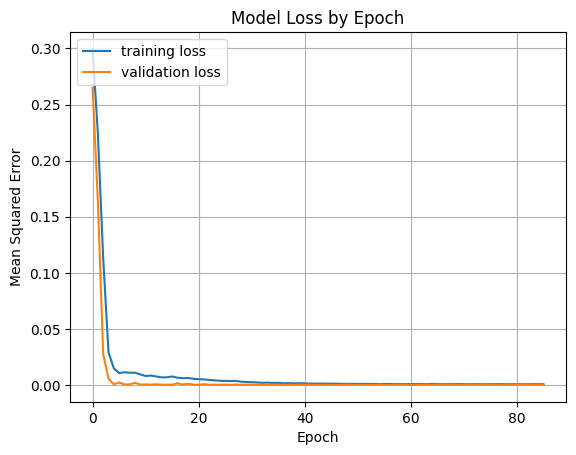

Final training loss: 0.0007470913697034121, validation loss: 0.0001524905819678679


In [ ]:
dataset_total = pd.concat((price_copy[target][:train_end],price_copy[target][test_start:]),axis=0)
inputs = dataset_total[len(dataset_total)-len(test_data) - past_days:].values
inputs = inputs.reshape(-1,1)
inputs  = sc.fit_transform(inputs)

X_test = []
for i in range(past_days,test_data.shape[0] + past_days):
    X_test.append(inputs[i-past_days:i,0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
predicted_stock_price = Transformer.predict(X_test)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss by Epoch')
plt.ylabel('Mean Squared Error')
plt.xlabel('Epoch')
plt.grid()
plt.legend(['training loss','validation loss'], loc='upper left')
plt.show()
print(f"Final training loss: {history.history['loss'][-1]}, validation loss: {history.history['val_loss'][-1]}")
# plot_return_predictions(test_set_return,predicted_return,"AAPL")
# return_rmse(test_set_return[1:], predicted_return[1:])

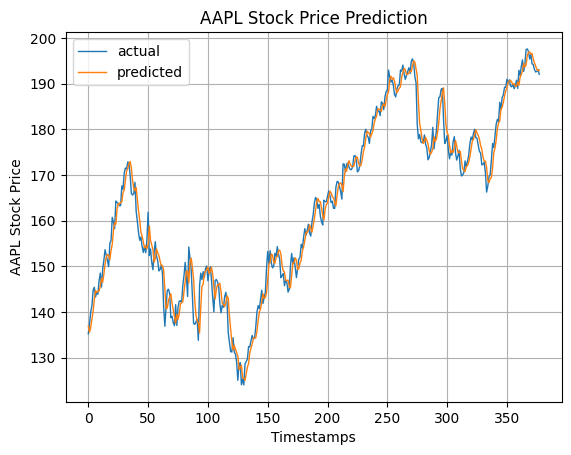

The mean squared error on the test dataset is 8.314780416553187, root mean squared error on the test dataset is 2.883536095933808.


In [ ]:
plt.plot(test_data, label=f'Actual', linewidth = 1)
plt.plot(predicted_stock_price, label=f'Predicted', linewidth = 1)
plt.grid()
plt.title(f'{ticker} Stock Price Prediction')
plt.xlabel('Timestamps')
plt.ylabel(f'{ticker} Stock Price')
plt.legend()
plt.show()

rmse = math.sqrt(mean_squared_error(test_data, predicted_stock_price))
print(f"The mean squared error on the test dataset is {mean_squared_error(test_data, predicted_stock_price)}, root mean squared error on the test dataset is {rmse}.")

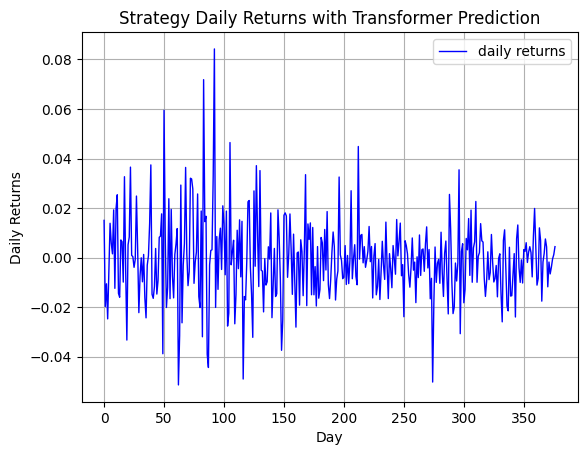

In [ ]:
def calculate_returns_and_sharpe_ratio(predicted_prices, actual_prices, risk_free_rate, transaction_cost=0.001):
    """
    Calculate daily returns and Sharpe ratio for a trading strategy based on predicted and actual stock prices.

    Parameters:
    predicted_prices (numpy.ndarray): Predicted stock prices.
    actual_prices (numpy.ndarray): Actual stock prices.
    risk_free_rate (float): Annualized risk-free rate, assuming 252 trading days in a year.
    transaction_cost (float, optional): Transaction cost percentage. Defaults to 0.001.

    Returns:
    list, float: List of daily returns and Sharpe ratio.
    """
    st = [1 if predicted_prices[i] > actual_prices[i] else -1 for i in range(len(predicted_prices) - 1)]
    daily_returns = [st[i] * np.log(actual_prices[i + 1] / actual_prices[i])-transaction_cost for i in range(len(st))]
    expected_return = np.mean(daily_returns)
    std_deviation = np.std(daily_returns)
    if std_deviation == 0:
        sharpe_ratio = 0
    else:
        sharpe_ratio = (expected_return - risk_free_rate) / std_deviation
    return daily_returns, sharpe_ratio

risk_free_rate = 0.02 / 252  #Annualized risk-free rate, assuming 252 trading days in a year
daily_returns, sharpe_ratio = calculate_returns_and_sharpe_ratio(predicted_stock_price, test_data, risk_free_rate)

plt.plot(daily_returns, label = 'daily returns',color='blue', linewidth = 1)
plt.title(f'Strategy Daily Returns with Transformer Prediction')
plt.xlabel('Day')
plt.ylabel('Daily Returns')
plt.grid()
plt.legend()
plt.show()
